# Jupyter notebook for debugging

In [2]:
%load_ext autoreload
%autoreload 2

# Copied from `train` function in train_simple.py:L78
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from models.yolo import Model
from utils.general import check_dataset

cfg = 'models/yolov5n_nuscenes.yaml'
data = 'data/nuscenes.yaml'
data_dict = check_dataset(data)

nc = int(data_dict["nc"])  # number of classes
model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

/home/user/anaconda3/envs/mylec/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Overriding model.yaml nc=4 with nc=15

                 from  n    params  module                                  arguments                     
  0                -1  1      1760  models.common.Conv                      [3, 16, 6, 2, 2]              
  1                -1  1      4672  models.common.Conv                      [16, 32, 3, 2]                
  2                -1  1      4800  models.common.C3                        [32, 32, 1]                   
  3                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  4                -1  2     29184  models.common.C3                        [64, 64, 2]                   
  5                -1  1     73984  models.common.Conv

In [8]:
anchors = model.model[-1].anchors

# [TODO] Draw anchors
anchors  # torch.Size([3, 1, 2])

tensor([[[2.00000, 3.75000]],

        [[3.87500, 2.81250]],

        [[4.87500, 6.18750]]])

In [15]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr

imgsz = 416
batch_size = 1
single_cls = False
seed = 0

train_path = data_dict["train"]
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=True,
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=True,
    seed=seed,
)

train: Scanning /home/user/sh/LEC/nuscenes_det2d/train.cache... 28130 images, 1425 backgrounds, 0 corrupt: 100%|██████████| 28130/28130 [00:00<?, ?it/s]


In [19]:
for imgs, targets, paths, _ in train_loader:
    imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0
    break
imgs.shape

torch.Size([1, 3, 416, 416])

In [36]:
import torch
from models.common import DetectMultiBackend
from utils.torch_utils import select_device

weights = 'yolov5n.pt'
# data = 'data/nuscenes.yaml'
data = 'data/coco128.yaml'
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('0')  # 'cpu

model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)

# inference
model.eval()
with torch.no_grad():
    pred = model(imgs)  # forward

YOLOv5 🚀 ddf4e91 Python-3.8.19 torch-1.13.1 CUDA:0 (NVIDIA RTX 5000 Ada Generation, 32358MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients


In [37]:
from utils.general import non_max_suppression

conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None
agnostic_nms = False  # class-agnostic NMS

pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# [TODO] draw predictions (see detect.py:L178)


YOLOv5 🚀 ddf4e91 Python-3.8.19 torch-1.13.1 CUDA:0 (NVIDIA RTX 5000 Ada Generation, 32358MiB)

Fusing layers... 
YOLOv5n_nuscenes summary: 157 layers, 1761420 parameters, 0 gradients, 4.1 GFLOPs


# [TODO] Draw architecture

In [ ]:
import torch
from torchviz import make_dot
from models.yolo import Model
from utils.general import check_dataset

cfg_path = "./models/yolov5n_nuscenes.yaml"
data_path = "./data/nuscenes.yaml"

data_dict = check_dataset(data_path)
nc = int(data_dict["nc"])  # number of classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(cfg_path, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)

# input (random data)
dummy_input = torch.randn(1, 3, 416, 416).to(device)

# output
output = model(dummy_input)
output_to_visualize = output[0]

dot = make_dot(output_to_visualize)
dot.format = 'png'
dot.render('./yolov5_model_graph', format='png', cleanup=True)

# [TODO] Qualitative evaluation

In [4]:
import os

folder_path = "./datasets/nuscenes/test/images/"
files = os.listdir(folder_path)
files[:5]  # sample test data

['n008-2018-08-01-16-03-27-0400__CAM_FRONT__1533154317762404.jpg',
 'n008-2018-09-18-14-18-33-0400__CAM_FRONT__1537295442162404.jpg',
 'n008-2018-08-28-15-47-40-0400__CAM_FRONT__1535486648412404.jpg',
 'n015-2018-08-03-12-54-49+0800__CAM_FRONT__1533272183612460.jpg',
 'n008-2018-08-28-16-05-27-0400__CAM_FRONT__1535486873912404.jpg']

In [7]:
!python detect.py --source "./datasets/nuscenes/test/images/n008-2018-08-01-16-03-27-0400__CAM_FRONT__1533154317762404.jpg" --weights "./runs/train/yolov5n/weights/best.pt" --conf 0.25
!python detect.py --source "./datasets/nuscenes/test/images/n008-2018-09-18-14-18-33-0400__CAM_FRONT__1537295442162404.jpg" --weights "./runs/train/yolov5n/weights/best.pt" --conf 0.25
!python detect.py --source "./datasets/nuscenes/test/images/n008-2018-08-28-15-47-40-0400__CAM_FRONT__1535486648412404.jpg" --weights "./runs/train/yolov5n/weights/best.pt" --conf 0.25
!python detect.py --source "./datasets/nuscenes/test/images/n015-2018-08-03-12-54-49+0800__CAM_FRONT__1533272183612460.jpg" --weights "./runs/train/yolov5n/weights/best.pt" --conf 0.25

detect: weights=['./runs/train/yolov5n/weights/best.pt'], source=./datasets/nuscenes/test/images/n008-2018-08-01-16-03-27-0400__CAM_FRONT__1533154317762404.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 ddf4e91 Python-3.8.19 torch-1.13.1 CUDA:0 (NVIDIA RTX 5000 Ada Generation, 32358MiB)

Fusing layers... 
YOLOv5n_nuscenes summary: 157 layers, 1761420 parameters, 0 gradients, 4.1 GFLOPs
image 1/1 /home/user/sh/LEC/nuscenes_det2d/test/images/n008-2018-08-01-16-03-27-0400__CAM_FRONT__1533154317762404.jpg: 384x640 10 cars, 12.1ms
Speed: 0.3ms pre-process, 12.1ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)


# [TODO] Train a better detector

/home/user/anaconda3/envs/mylec/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


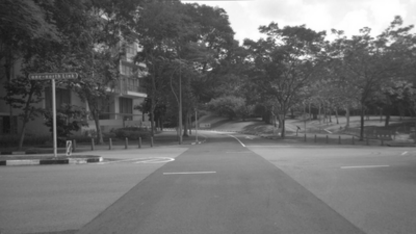

In [8]:
import torchvision.transforms as transforms
from PIL import Image

image_path = "./datasets/nuscenes/train/images/fffce4445c964803a12a2d64023fde40.png"
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3)
])

augmented_image = transform(image)
augmented_image

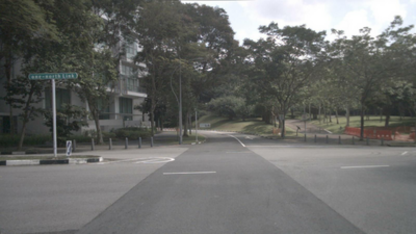

In [14]:
image  # 원본 이미지